In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [81]:
group_run = "/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv15f_group/"
doping_run = "/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv15f_dopings"
template_from = "/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv15f_group/"
one_run = "/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv10f_group/run-TTS_1/template/outputs/template_sample.h5"
features = ["m_j1", "del_m", "del_R", "tau21_j1", "tau21_j2",  "m_jj"]

In [82]:
save_folder = "/home/users/o/oleksiyu/WORK/hyperproject/plots/ML4J/"
os.makedirs(save_folder, exist_ok=True)

In [83]:
df = pd.read_hdf("/home/users/o/oleksiyu/scratch/DATA/LHCO/events_anomalydetection_v2.features_prepCURTAINS.h5")

In [84]:
df_sig = df[df["is_signal"]==True]
df_bkg = df[df["is_signal"]==False]
df_bkg_sr = df_bkg[df_bkg["m_jj"]>3300]
df_bkg_sr = df_bkg_sr[df_bkg_sr["m_jj"]<3700]

In [85]:
df_bkg_sr

,is_signal,px_j1,py_j1,pz_j1,m_j1,pt_j1,phi_j1,eta_j1,p_j1,e_j1,...,m_jj,del_m,tau21_j1,tau32_j1,tau21_j2,tau32_j2,m_n,del_R,del_phi,del_eta
0,False,-1467.239990,611.502014,511.101990,38.896000,1589.568464,2.746713,0.316238,1669.716487,1670.169466,...,3307.219387,198.997997,0.583317,0.880918,0.263237,0.797590,3030.429390,3.146662,3.088470,0.602360
53,False,1196.349976,561.049988,-64.198502,146.166000,1321.374418,0.438515,-0.048566,1322.933029,1330.983208,...,3563.933001,3.876007,0.593233,0.792424,0.747219,0.852569,3267.724994,3.487259,3.047086,1.695949
60,False,437.184998,1360.010010,-1364.130005,185.050995,1428.550996,1.259772,-0.849124,1975.249002,1983.898306,...,3336.961354,90.123993,0.674910,0.603939,0.744809,0.734496,2876.735372,3.166353,2.933906,1.190792
68,False,-1258.699951,1012.309998,942.002014,181.179993,1615.269977,2.464265,0.554353,1869.883658,1878.640754,...,3472.849614,97.941010,0.629373,0.650525,0.462002,0.779867,3012.548619,2.965060,2.826204,0.896747
81,False,807.778992,-1086.300049,-2300.449951,67.803001,1353.718839,-0.931400,-1.300494,2669.199257,2670.060284,...,3358.943097,171.510994,0.584220,0.588408,0.559757,0.679305,3051.826101,3.491847,3.139809,1.527939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049858,False,-14.563800,-1120.099976,-652.872986,211.809998,1120.194653,-1.583798,-0.554038,1296.564381,1313.751373,...,3462.368211,8.022995,0.467944,0.790485,0.465897,0.788281,3030.725220,3.527699,3.100661,1.682427
1049863,False,727.786011,926.698975,1359.760010,78.853798,1178.322310,0.905050,0.986175,1799.275063,1801.002130,...,3459.228117,181.539207,0.474347,0.751596,0.523599,0.752784,3119.981314,3.513321,3.125202,1.605159
1049875,False,59.328201,-1442.920044,611.273987,158.774002,1444.139221,-1.529703,0.411562,1568.181742,1576.198959,...,3601.049364,58.750000,0.595861,0.776109,0.533434,0.661217,3224.751360,3.403007,3.140525,1.310558
1049878,False,-1133.000000,533.672974,-527.125977,21.905600,1252.396041,2.701391,-0.409364,1358.807432,1358.983993,...,3427.125197,601.750406,0.790399,0.799534,0.308047,0.516920,2781.563591,3.514344,3.141545,1.575216


In [86]:
# load template and reverse transform it:
template = pd.read_hdf(one_run)
template_numpy=template[features].to_numpy()


In [87]:
import pyrootutils
import os
import torch
root = pyrootutils.setup_root(search_from=os.path.abspath(''), pythonpath=True, cwd=True, indicator=".project-root")
processor = pickle.load(open("/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv10f_group/run-TTS_1/cathode_preprocessor.pkl", "rb"))

In [88]:
template_numpy_tr=processor.inverse_transform(torch.Tensor(template_numpy))

In [89]:
template_tr = pd.DataFrame(template_numpy_tr, columns=features)

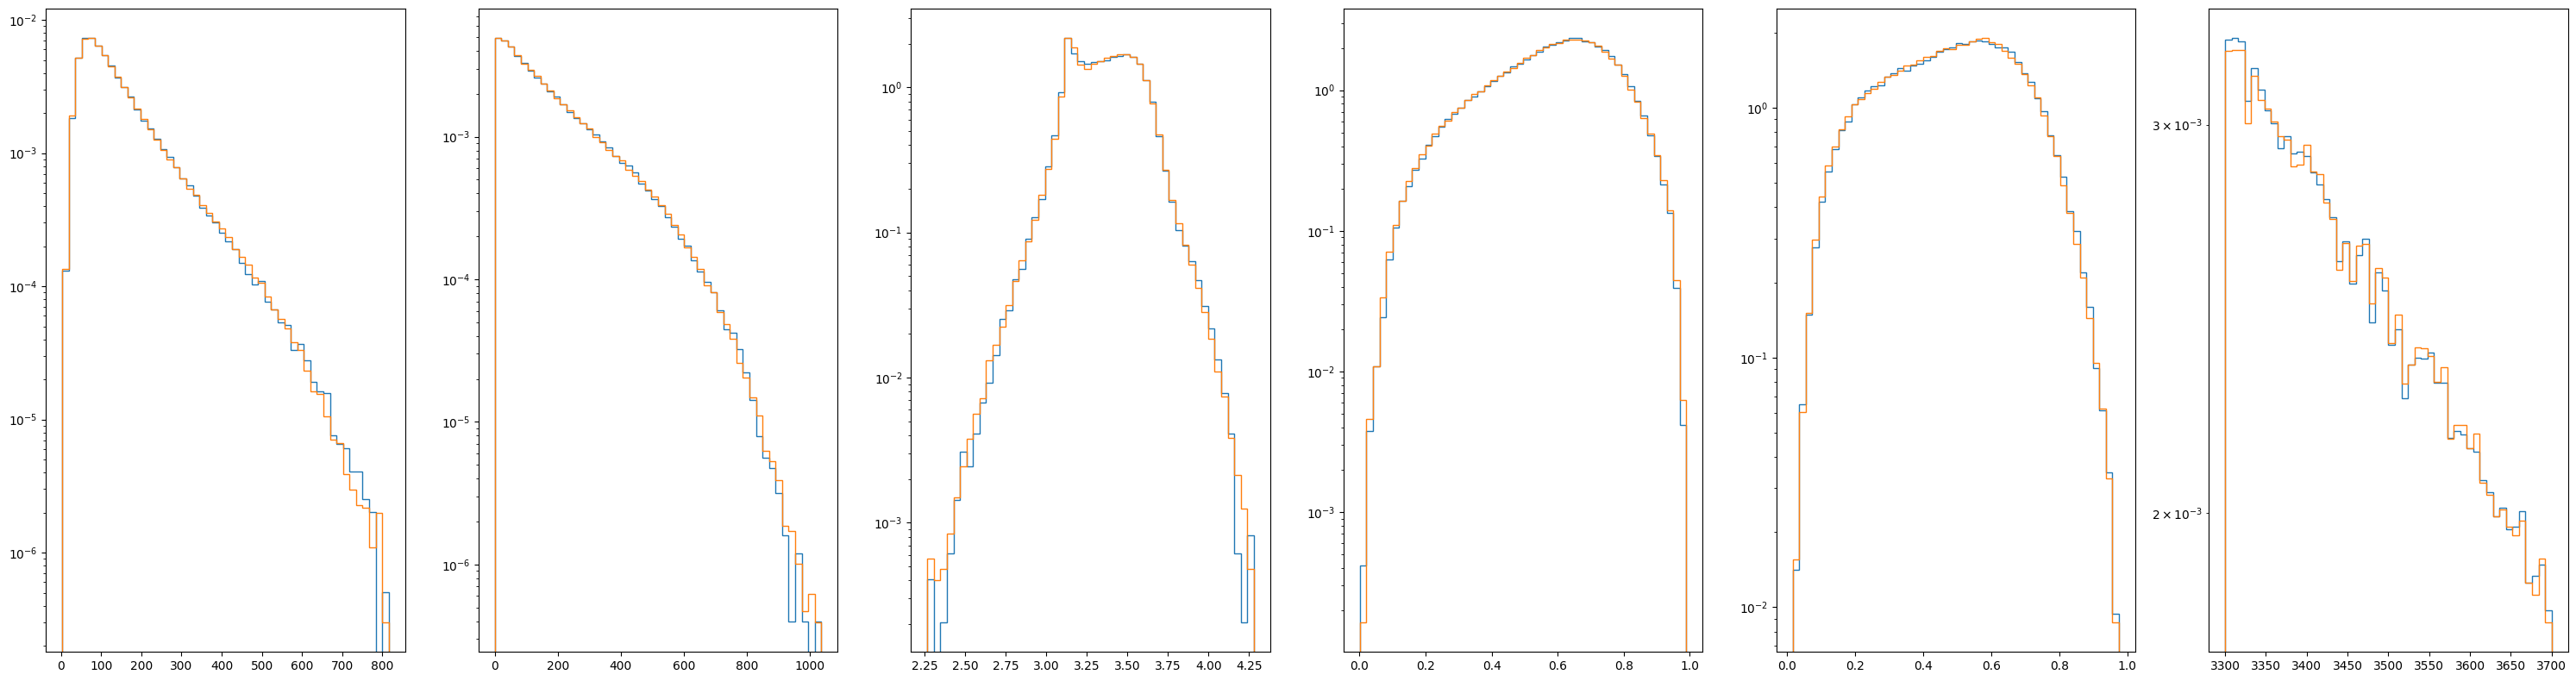

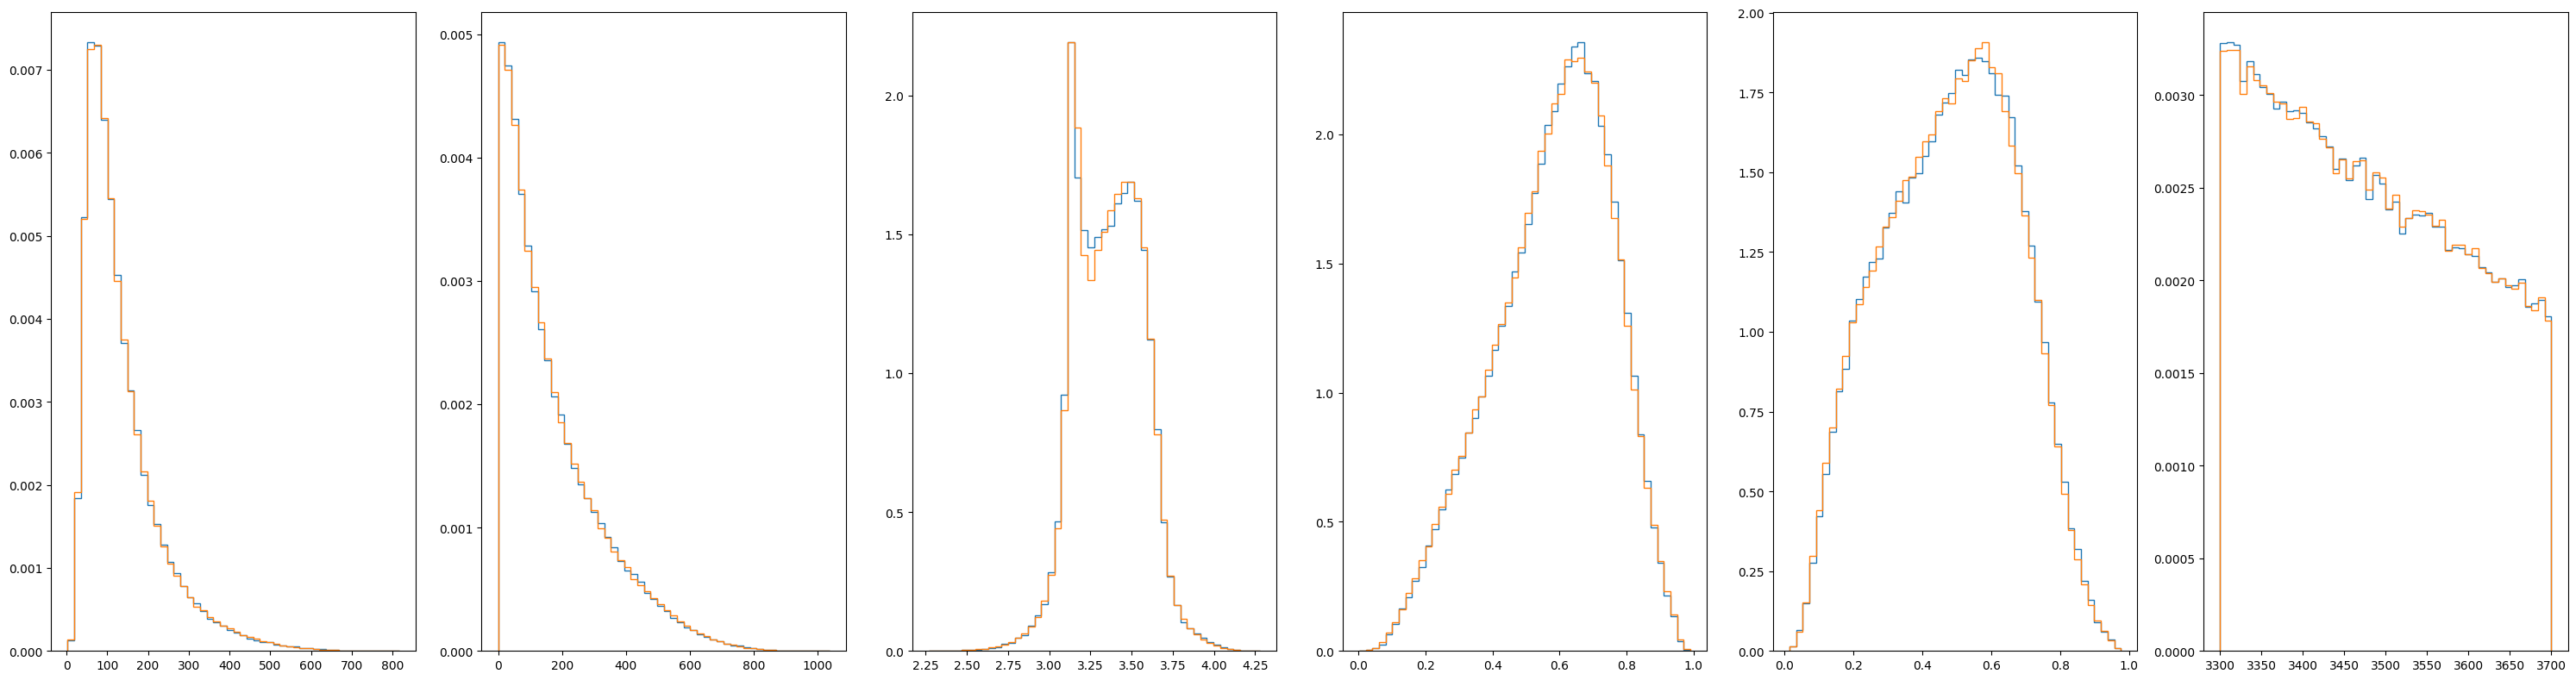

In [90]:
def plot_histograms(databases, columns, log_scale=False):
    """
    Function to plot histograms of selected columns from multiple databases.
    
    Parameters:
    databases: list of pandas DataFrames (databases containing same columns)
    columns: list of columns (column names to plot)
    
    Returns:
    Displays histograms of each column in a single row.
    """
    # Number of columns to plot
    num_columns = len(columns)
    
    # Create a figure with subplots, one for each column in one row
    fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 8)) #, gridspec_kw={'height_ratios': [4, 1]}

    # Loop over the columns
    counts={}
    for i, column in enumerate(columns):
        # Merge the same column from all databases into one for easy plotting
        counts[column] = []
        plt.sca(axes[i])
        bins = 50
        # Plot the histogram in the corresponding subplot
        for db in databases:
            counts_temp, bins, _ =plt.hist(db[column], bins=bins, histtype='step', density=True)
            counts[column].append(counts_temp)
            if log_scale:
                plt.yscale('log')
        
        # # plot differecwsa on bottom subplots
        # plt.sca(axes[i+num_columns])
        
        # #axes[i].set_title(f'Histogram of {column}')
        # axes[i].set_xlabel(column)
        # if i == 0:
        #     axes[i].set_ylabel('Density')
        # if log_scale:
        #     axes[i].set_yscale('log')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    

plot_histograms([df_bkg_sr, template_tr], features, log_scale=True)
plot_histograms([df_bkg_sr, template_tr], features, log_scale=False)

In [91]:

N_EVENTS_SR = len(df_bkg_sr["m_jj"].values)
print(N_EVENTS_SR)

121339


In [92]:
# load my curves
my_curver_rej = np.load(group_run+"plots/compare/TwinTurbo_rejection_v_TPR_comb_seeds_CWOLA.npy")
my_curve_sic = np.load(group_run+"plots/compare/TwinTurbo_SI_v_rej_comb_seeds_CWOLA.npy")
#print(my_curver_rej)

In [93]:
# load CURTAINSF4F
npy_file =  "/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_8/seed_0/rejection_v_TPR.npy"
curtains_rej = np.load(npy_file)
npy_file =  "/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_8/seed_0/SI_v_rej.npy"
curtains_sic = np.load(npy_file)

In [94]:
# Load supervised 
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/radot_rej_3000.csv'
radot1 = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/radot_tpr_3000.csv'
radot2 = pd.read_csv(csv_file_path)
#print(radot1.head())

In [95]:
# Load Idealised 
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/rej_vs_tpr_3000_idealised.csv'
ideal_rej = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/sic_vs_reg_3000_idealised.csv'
ideal_sic = pd.read_csv(csv_file_path)

In [96]:
# load RADOT curves
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/rej_vs_tpr_3000_supervised.csv'
super_rej = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/sic_vs_reg_3000_supervised.csv'
super_sic = pd.read_csv(csv_file_path)
#print(radot1.head())

In [97]:
from scipy.interpolate import interp1d
def filter_finite_values(x):
    return x[np.isfinite(x)]

In [98]:
def get_curve(files):
    curves = []
    for file in files:
        curves.append(np.load(file))
    # Aggregate the curves that might have different x values (use interpolation)
    if len(curves) == 1:
        return [curves[0][0], curves[0][1], 0]
    # Sort curves so that x is always rising
    for curve in curves:
        if curve[0][0] > curve[0][-1]:
            curve[0] = curve[0][::-1]
            curve[1] = curve[1][::-1]
        else:
            curve[0] = curve[0]
            curve[1] = curve[1]
    
    # Find the largest x range that all curves have
    min_x = max([filter_finite_values(curve[0])[0] for curve in curves])
    max_x = min([filter_finite_values(curve[0])[-1] for curve in curves])
    
    # get a common x range
    common_x = np.sort(np.unique(np.concatenate([filter_finite_values(curve[0]) for curve in curves])))
    common_x = common_x[(common_x >= min_x) & (common_x <= max_x)]
    
    # Interpolate the y values for each curve
    interpolated_y = []
    for xy in curves:
        x = xy[0]
        y = xy[1]
        interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=(y[0], y[-1]))
        interpolated_y.append(interp_func(common_x))
    
    # Convert the list of arrays into a 2D array for easier computation
    interpolated_y = np.array(interpolated_y)

    # Calculate the mean and standard deviation at each x-value
    y_up = np.percentile(interpolated_y, 84, axis=0)
    y_center = np.percentile(interpolated_y, 50, axis=0)
    y_down = np.percentile(interpolated_y, 16, axis=0)
    
    mean_y = np.mean(interpolated_y, axis=0)
    std_y = np.std(interpolated_y, axis=0)
            
    return {"x": common_x, "mean_y": mean_y, "std_y": std_y, "y_up": y_up, "y_down": y_down, "y_center": y_center}

In [99]:
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/standard/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
RADOT_curve = get_curve(files)
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/supervised/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
supervised_curve = get_curve(files)
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/idealised/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
idealised_curve = get_curve(files)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


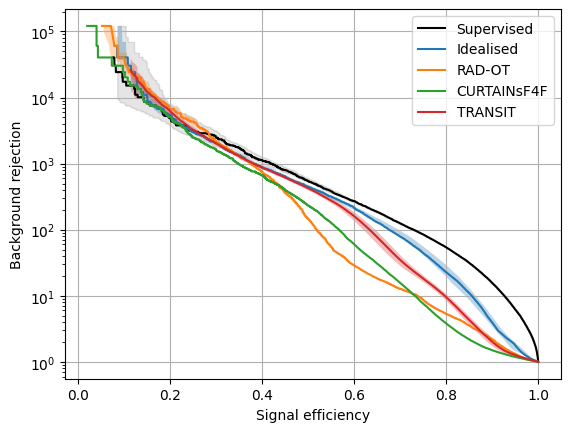

In [100]:
plt.figure()
plt.plot(supervised_curve["x"], supervised_curve["y_center"], label="Supervised", color="black")
plt.fill_between(supervised_curve["x"], supervised_curve["y_down"], supervised_curve["y_up"], alpha=0.1, color="black")
plt.plot(idealised_curve["x"], idealised_curve["y_center"], label="Idealised")
plt.fill_between(idealised_curve["x"], idealised_curve["y_down"], idealised_curve["y_up"], alpha=0.3)
plt.plot(RADOT_curve["x"], RADOT_curve["y_center"], label="RAD-OT")
plt.fill_between(RADOT_curve["x"], RADOT_curve["y_down"], RADOT_curve["y_up"], alpha=0.3)

plt.plot(curtains_rej[0], curtains_rej[1], label="CURTAINsF4F")
plt.fill_between(curtains_rej[0], curtains_rej[1]-0, curtains_rej[1]+0, alpha=0.3)
plt.plot(my_curver_rej[0], my_curver_rej[1], label="TRANSIT")
plt.fill_between(my_curver_rej[0], my_curver_rej[1]-my_curver_rej[2], my_curver_rej[1]+my_curver_rej[2], alpha=0.3)
plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.savefig(save_folder+"inverse_rej.png", dpi=300, bbox_inches='tight')

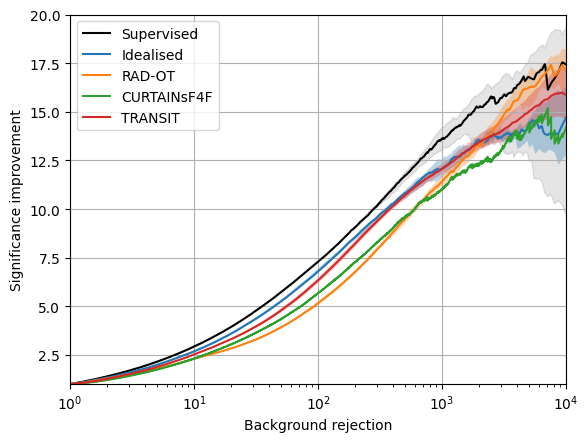

In [101]:
plt.figure()
plt.plot(super_sic["x"], super_sic["y_center"], label="Supervised", color="black")
plt.fill_between(super_sic["x"], super_sic["y_down"], super_sic["y_up"], alpha=0.1, color="black")
plt.plot(ideal_sic["x"], ideal_sic["y_center"], label="Idealised")
plt.fill_between(ideal_sic["x"], ideal_sic["y_down"], ideal_sic["y_up"], alpha=0.3)
plt.plot(radot2["rejection"], radot2["tpr_center"], label="RAD-OT")
plt.fill_between(radot2["rejection"], radot2["tpr_down"], radot2["tpr_up"], alpha=0.3)
plt.plot(curtains_sic[0], curtains_sic[1], label="CURTAINsF4F")
plt.fill_between(curtains_sic[0], curtains_sic[1]-0, curtains_sic[1]+0, alpha=0.3)
plt.plot(my_curve_sic[0], my_curve_sic[1], label="TRANSIT")
plt.fill_between(my_curve_sic[0], my_curve_sic[1]-my_curve_sic[2], my_curve_sic[1]+my_curve_sic[2], alpha=0.3)
plt.xscale("log")
plt.xlim(1, 10000)
plt.ylim(1, 20)
plt.xlabel("Background rejection")
plt.ylabel("Significance improvement")
plt.grid()
plt.legend()
plt.savefig(save_folder+"SIC.png", dpi=300, bbox_inches='tight')

In [102]:
def linear_interpolation(x, y, x_new):
    # Convert lists to numpy arrays for easier manipulation
    x = np.array(x)
    y = np.array(y)

    # Ensure that x_new is within the range of x
    if x_new < np.min(x) or x_new > np.max(x):
        raise ValueError("x_new is out of bounds of x.")

    # Find indices of the two closest values in x that bound x_new
    idx = np.searchsorted(x, x_new)
    
    # Handle edge case where x_new matches exactly the smallest or largest x value
    if x_new == x[idx - 1]:
        return y[idx - 1]
    elif x_new == x[idx]:
        return y[idx]

    # Get the two x and y values surrounding x_new
    x0, x1 = x[idx - 1], x[idx]
    y0, y1 = y[idx - 1], y[idx]

    # Perform linear interpolation
    y_new = y0 + (y1 - y0) * (x_new - x0) / (x1 - x0)

    return y_new

## Plot the SI vs Rejection curves

In [103]:
folder = doping_run
dopings = [50, 100, 333, 500, 667, 1000, 3000]

In [104]:
SI_vs_rejinv_curves = []
def get_y_and_std_curves(curves, x):
    y = []
    for curve in curves:
        y += [linear_interpolation(curve[0], curve[1], x)]
    return np.mean(y), np.std(y)

In [105]:
n_dope_per_run=[0, 50, 100, 333, 500, 667, 1000, 3000]
runs = [0, 1, 2, 4, 5, 6, 7, 8]
def getSI_vs_doping_CURTAINS(target_inv_rej):
    # plt.figure()
    SIs =[]
    SI_stds = []
    for run, doping in zip(runs, n_dope_per_run):
        SI_rejs = []
        for seed in range(5):
            SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_{run}/seed_{seed}/SI_v_rej.npy"
            SI_rej = np.load(SI_curve_file)
            SI_rej[0] = np.flip(SI_rej[0])
            SI_rej[1] = np.flip(SI_rej[1])
            SI_rejs += [SI_rej]
        y, y_std = get_y_and_std_curves(SI_rejs, target_inv_rej)
        SIs += [y]
        SI_stds += [y_std]
    return SIs, SI_stds

In [106]:
SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_CURTAINS(100)
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "CURTAINsF4F",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_CURTAINS(1000)
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "CURTAINsF4F",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

In [107]:
# get curves for curtains
n_dope_per_run=[0, 50, 100, 333, 500, 667, 1000, 3000]

SIs_CURTAINS_100 = []
SIs_CURTAINS_1000 = []

def getSI_vs_doping_RADOT(target_inv_rej, mode="standard"):
    # plt.figure()
    SIs =[]
    SI_stds = []
    for run, doping in zip(runs, n_dope_per_run):
        SI_rejs = []
        for seed in range(5):
            SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_{doping}/{mode}/seed_{seed}/SI_v_rej.npy"
            SI_rej = np.load(SI_curve_file)
            SI_rej[0] = np.flip(SI_rej[0])
            SI_rej[1] = np.flip(SI_rej[1])
            SI_rejs += [SI_rej]
            #plt.plot(SI_rej[0], SI_rej[1], label=f"{doping}")
        y, y_std = get_y_and_std_curves(SI_rejs, target_inv_rej)
        SIs += [y]
        SI_stds += [y_std]
    # plt.grid()
    # plt.ylabel("SI")
    # plt.xlabel("1/Rejection rate")
    # plt.axvline(100, color='black')
    # plt.xscale('log')
    # plt.legend()
    return SIs, SI_stds



SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "supervised")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "Supervised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err),
                         "color": "black"}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "supervised")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "Supervised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err),
                         "color": "black"}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "idealised")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "Idealised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "idealised")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "Idealised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "standard")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "RAD-OT",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "standard")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "RAD-OT",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

In [108]:
def getSI_vs_doping_curve_TRANSIT(target_inv_rej):
    SIs = []
    SI_errs = []
    for doping in dopings:
        SI_curve_file = f"{folder}/run-doping_{doping}/plots/compare/TwinTurbo_SI_v_rej_comb_seeds_CWOLA.npy"
        SI_rej = np.load(SI_curve_file)
        rej_inv = SI_rej[0]
        SI = SI_rej[1]
        SI_err = SI_rej[2]
        #plt.plot(rej_inv, SI, marker='o', label=f"{doping}")
        SIs.append(linear_interpolation(rej_inv, SI, target_inv_rej))
        SI_errs.append(linear_interpolation(rej_inv, SI_err, target_inv_rej))
    return np.array(SIs), np.array(SI_errs)

In [109]:
SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(100)
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "TRANSIT",
                         "x": np.array(dopings),
                         "y": SIs,
                         "y_err": SI_errs}]

In [110]:
SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(1000)
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "TRANSIT",
                         "x": dopings,
                         "y": SIs,
                         "y_err": SI_errs}]

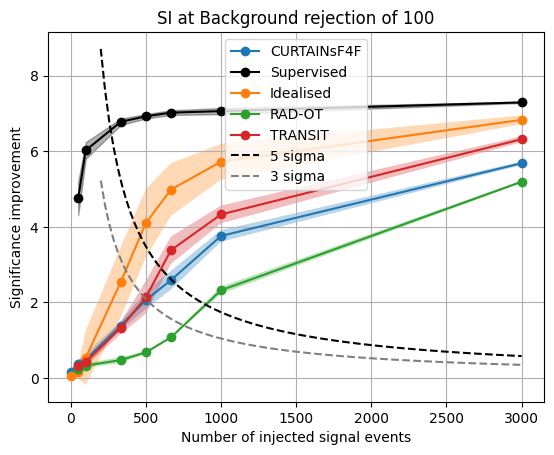

In [111]:
rej_target = 100
curve_order = ["Supervised", "Idealised", "CURTAINsF4F", "RAD-OT", "TRANSIT"]
for curve in SI_vs_rejinv_curves:
    if f"invrej_{rej_target}" in curve["tags"]:
        #print(curve)
        plt.plot(curve["x"], curve["y"], marker='o', label=curve["label"], color = curve.get("color", None))
        if curve.get("color", None) is not None:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3, color = curve["color"])
        else:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3)
plt.grid()
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 5/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="black", label="5 sigma", linestyle="--")
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 3/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="gray", label="3 sigma", linestyle="--")
plt.ylabel("Significance improvement")
plt.xlabel("Number of injected signal events")
plt.title(f"SI at Background rejection of {rej_target}")
plt.legend()
plt.savefig(save_folder+f"SI_vs_doping_{rej_target}.png", dpi=300, bbox_inches='tight')

{'tags': ['invrej_1000'], 'label': 'CURTAINsF4F', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([ 0.04854918,  0.05014942,  0.14817096,  1.21768288,  2.26648121,
        3.69879674,  6.56688776, 11.02916168]), 'y_err': array([0.03518622, 0.02829857, 0.06022399, 0.21626019, 0.51226952,
       0.57557767, 0.44212342, 0.2892685 ])}
{'tags': ['invrej_1000'], 'label': 'Supervised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([        nan,  4.45216643,  9.99517426,  9.40730374, 12.66804366,
       12.19796346, 11.48285221, 13.24014109]), 'y_err': array([       nan, 0.77761548, 1.65325205, 4.69513488, 0.60850699,
       0.81017387, 0.76856844, 0.46258479]), 'color': 'black'}
{'tags': ['invrej_1000'], 'label': 'Idealised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([2.25431830e-03, 3.11565959e-02, 6.28092750e-01, 2.96683788e+00,
       5.28009788e+00, 9.67483193e+00, 1.06612386e+01, 1.20742427e+01]), 'y_err':

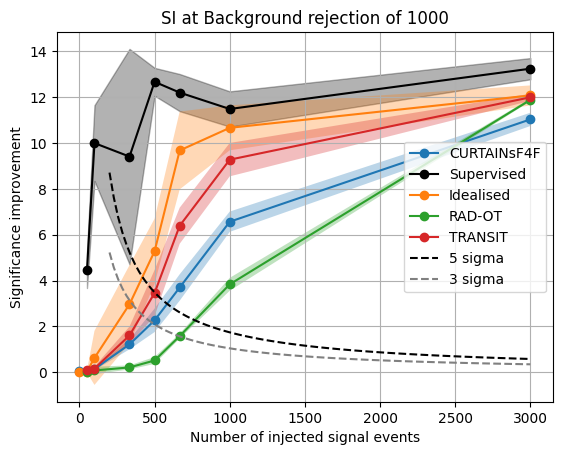

In [112]:

rej_target = 1000
curve_order = ["Supervised", "Idealised", "CURTAINsF4F", "RAD-OT", "TRANSIT"]
for curve in SI_vs_rejinv_curves:
    if f"invrej_{rej_target}" in curve["tags"]:
        print(curve)
        plt.plot(curve["x"], curve["y"], marker='o', label=curve["label"], color = curve.get("color", None))
        if curve.get("color", None) is not None:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3, color = curve["color"])
        else:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3)
plt.grid()
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 5/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="black", label="5 sigma", linestyle="--")
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 3/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="gray", label="3 sigma", linestyle="--")
plt.ylabel("Significance improvement")
plt.xlabel("Number of injected signal events")
plt.title(f"SI at Background rejection of {rej_target}")
plt.legend()
plt.savefig(save_folder+f"SI_vs_doping_{rej_target}.png", dpi=300, bbox_inches='tight')
